In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

from os.path import isfile, join, splitext
from glob import glob
from datetime import datetime

import json
import numpy as np
import sys

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

/local/tarciso/programs/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [44]:
def get_files(path, sqlContext, sc, initial_date, final_date):

    path_pattern = path + "/*"
    if "hdfs" in path:
        URI = sc._gateway.jvm.java.net.URI
        Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
        FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
        Configuration = sc._gateway.jvm.org.apache.hadoop.conf.Configuration

        hdfs = "/".join(path_pattern.split("/")[:3])
        dir = "/" + "/".join(path_pattern.split("/")[3:])

        fs = FileSystem.get(URI(hdfs), Configuration())

        status = fs.globStatus(Path(dir))

        files = map(lambda file_status: str(file_status.getPath()), status)

    else:
        files = glob(path_pattern)

    files = filter(lambda f: initial_date <= datetime.strptime(f.split("/")[-1], '%Y_%m_%d.csv') <=
    final_date, files)

    return files

def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_df_from_hdfs(filepath, sqlContext):
    data_frame = sqlContext.read.csv(filepath, header=True, inferSchema=True,nullValue="-")
    return data_frame

def dist(lat_x, long_x, lat_y, long_y):
    return F.acos(
        F.sin(F.toRadians(lat_x)) * F.sin(F.toRadians(lat_y)) +
        F.cos(F.toRadians(lat_x)) * F.cos(F.toRadians(lat_y)) *
            F.cos(F.toRadians(long_x) - F.toRadians(long_y))
    ) * F.lit(6371.0)

def buildODMatrix(buste_data, datapath, file_name):
    return buste_crowdedness_extrapolated

def execute_job(input_folder, sqlContext, sc, initial_date, final_date):

    files = get_files(input_folder, sqlContext, sc, initial_date, final_date)

    for file in files:
        data = read_buste_data_v3(file, sqlContext)
        file_date = file.split("/")[-1]
        result = buildODMatrix(data, output_folder, file_date)
        result.write.csv(path=output_folder + '/od/buste_crowdedness/' + file_date + '_bc',header=True, mode='append')

def printdf(df,l=10):
    return df.limit(l).toPandas()

### Read BUSTE result Data

In [18]:
input_folder = '/local/tarciso/masters/data/bus_trips/test/enhanced-buste/'
output_folder = '/local/tarciso/masters/data/bus_trips/test/od/'
initial_date = datetime.strptime('2017-05-09', '%Y-%m-%d')
final_date = datetime.strptime('2017-05-09', '%Y-%m-%d')

In [19]:
global sc, sqlContext

#sc = SparkContext(appName="OD matrix Builder")
sqlContext = pyspark.SQLContext.getOrCreate(sc='OD matrix Builder')

In [20]:
#execute_job(input_folder, sqlContext, sc, initial_date, final_date)
files = get_files(input_folder, sqlContext, sc, initial_date, final_date)

In [21]:
#for file in files:
file = files[0]
buste_data = read_df_from_hdfs(file, sqlContext)
datapath = output_folder
file_name = file.split("/")[-1]
#result = buildODMatrix(data, output_folder, file_date)
#result.write.csv(path=output_folder + '/od/buste_crowdedness/' + file_date + '_bc',header=True, mode='append')

In [22]:
buste_data.printSchema()

root
 |-- cardNum: double (nullable = true)
 |-- boarding_datetime: timestamp (nullable = true)
 |-- route: string (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: double (nullable = true)
 |-- gps_datetime: timestamp (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- stop_lat: double (nullable = true)
 |-- stop_lon: double (nullable = true)
 |-- parent_station: double (nullable = true)
 |-- shapeId: double (nullable = true)
 |-- shapeSequence: double (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- problem: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- gender: string (nullable = true)



In [25]:
bus_trip_data = buste_data.na.drop(subset=["route","busCode","tripNum","stopPointId","gps_datetime","stop_lat","stop_lon"])

In [27]:
filtered_boardings = buste_data.na.drop(subset=['cardNum','boarding_datetime']).dropDuplicates(['cardNum','boarding_datetime'])

In [45]:
printdf(filtered_boardings)

,cardNum,boarding_datetime,route,busCode,tripNum,gps_datetime,stopPointId,stop_lat,stop_lon,parent_station,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,problem,lineName,birthdate,gender
0,328643.0,2017-05-09 18:20:59,000,03009,NaN,NaT,14499,-25.476335,-49.292629,NaN,NaN,NaN,NaN,NaN,NaN,None,OPER S/LINHA,16/11/80,M
1,341356.0,2017-05-09 09:57:08,663,EC008,4.0,2017-05-09 09:52:28,26631,-25.440706,-49.271456,NaN,2123.0,3921465.0,-25.440865,-49.271457,10158.065,BETWEEN,V. CUBAS,24/10/52,F
2,364763.0,2017-05-09 07:37:35,021,04020,NaN,NaT,14508,-25.441614,-49.346740,NaN,NaN,NaN,NaN,NaN,NaN,None,INTERB II ANTI H,07/01/65,F
3,429857.0,2017-05-09 08:03:01,000,03047,NaN,NaT,14553,-25.437655,-49.266632,NaN,NaN,NaN,NaN,NaN,NaN,None,OPER S/LINHA,01/02/56,M
4,452960.0,2017-05-09 20:02:59,373,CC192,13.0,2017-05-09 20:00:37,26338,-25.432890,-49.270402,NaN,1893.0,6328829.0,-25.432852,-49.270426,9525.202,NO_PROBLEM,ALTO TARUMÃ,10/11/85,F
5,463208.0,2017-05-09 17:52:01,040,HR113,2.0,2017-05-09 17:28:10,31029,-25.513203,-49.295115,14494.0,1717.0,3367323.0,-25.513207,-49.295155,23745.621,TRIP_PROBLEM,INTERBAIRROS IV,28/07/76,M
6,463902.0,2017-05-09 15:29:23,000,06022,NaN,NaT,26011,-25.435634,-49.256611,NaN,NaN,NaN,NaN,NaN,NaN,None,OPER S/LINHA,08/09/64,M
7,464476.0,2017-05-09 08:47:28,000,09045,NaN,NaT,47554,-25.477424,-49.285011,NaN,NaN,NaN,NaN,NaN,NaN,None,OPER S/LINHA,29/08/63,F
8,537146.0,2017-05-09 11:55:30,366,BC908,5.0,2017-05-09 11:55:27,29082,-25.430080,-49.274090,NaN,1886.0,6268150.0,-25.429959,-49.274060,2087.909,NO_PROBLEM,ITUPAV/H.MILITAR,11/06/53,F
9,611290.0,2017-05-09 09:12:22,TSP,09056,NaN,NaT,41902,-25.512840,-49.279851,NaN,NaN,NaN,NaN,NaN,NaN,None,TUBO SAO PEDRO,08/05/60,M


In [41]:
filtered_boardings.count()

277692

In [37]:
multiple_boardings = filtered_boardings.groupby('cardNum').count().filter(F.col('count') > 1) \
.select(F.col("cardNum").alias("cardNum1"), F.col("count").alias("count1"))

In [46]:
printdf(multiple_boardings)

,cardNum1,count1
0,1582225.0,2
1,1582656.0,2
2,2508689.0,3
3,2820738.0,3
4,3416099.0,2
5,3444607.0,3
6,3601911.0,2
7,3723941.0,2
8,3779032.0,2
9,1744594.0,6


In [39]:
clean_boardings = filtered_boardings.join(multiple_boardings, filtered_boardings.cardNum == multiple_boardings.cardNum1, 'leftsemi')

In [40]:
clean_boardings.count()

177756

In [43]:
boarding_data = clean_boardings.withColumn('boarding_id',F.monotonically_increasing_id())

In [ ]:
user_boarding_w = Window.partitionBy(boarding_data.cardNum, boarding_data.date).orderBy(boarding_data.cardTimestamp)

In [ ]:
od_matrix_ids = boarding_data.select(F.col('cardNum'),
F.col('boarding_id'),
F.lead('boarding_id',default=-1).over(user_boarding_w).alias('next_boarding_id'),
F.first('boarding_id',True).over(user_boarding_w).alias('first_boarding')).withColumn('next_boarding_id',
F.when(F.col('next_boarding_id') == -1,F.col('first_boarding'))
.otherwise(F.col('next_boarding_id'))).drop('first_boarding')

In [ ]:







origin_matrix = boarding_data.select(F.col("route").alias("o_route"),
F.col("busCode").alias("o_bus_code"),
F.col("date").alias("o_date"),
F.col("tripNum").alias("o_tripNum"),
F.col("cardTimestamp").alias("o_timestamp"),
F.col("shapeId").alias("o_shape_id"),
F.col("shapeSequence").alias("o_shape_seq"),
F.col("shapeLat").alias("o_shape_lat"),
F.col("shapeLon").alias("o_shape_lon"),
F.col("stopPointId").alias("o_stop_id"),
F.col("boarding_id").alias("o_boarding_id"))


next_origin_matrix = boarding_data.select(F.col("route").alias("next_o_route"),
F.col("busCode").alias("next_o_bus_code"),
F.col("date").alias("next_o_date"),
F.col("tripNum").alias("next_o_tripNum"),
F.col("cardTimestamp").alias("next_o_timestamp"),
F.col("shapeId").alias("next_o_shape_id"),
F.col("shapeSequence").alias("next_o_shape_seq"),
F.col("shapeLat").alias("next_o_shape_lat"),
F.col("shapeLon").alias("next_o_shape_lon"),
F.col("stopPointId").alias("next_o_stop_id"),
F.col("boarding_id").alias("next_o_boarding_id"))

user_trips_data = origin_matrix.join(od_matrix_ids, origin_matrix.o_boarding_id == od_matrix_ids.boarding_id, 'inner') \
.join(next_origin_matrix, od_matrix_ids.next_boarding_id == next_origin_matrix.next_o_boarding_id, 'inner') \
.drop('boarding_id').drop('next_boarding_id') \
.withColumn('o_unixtimestamp',F.unix_timestamp(F.col('o_timestamp'), 'HH:mm:ss')) \
.withColumn('next_o_unixtimestamp',F.unix_timestamp(F.col('next_o_timestamp'), 'HH:mm:ss')) \
.withColumn('leg_duration',F.when(F.col('next_o_unixtimestamp') > F.col('o_unixtimestamp'), \
((F.col('next_o_unixtimestamp') - F.col('o_unixtimestamp'))/60.0)).otherwise(-1)) \
.orderBy(['cardNum','o_date','o_timestamp'])
# .withColumn('o_date',F.from_unixtime(F.unix_timestamp(F.col('o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd'))\
# .withColumn('next_o_date',F.from_unixtime(F.unix_timestamp(F.col('next_o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \

bus_trip_data = clean_buste_data.orderBy(['route','busCode','tripNum','timestamp']) \
.dropDuplicates(['route','busCode','tripNum','stopPointId']) \
.drop('cardNum') \
.withColumn('id',F.monotonically_increasing_id()) \
.withColumn('route', F.col('route').cast(T.IntegerType())) \
.withColumnRenamed('','cardNum')

cond = [bus_trip_data.route == user_trips_data.o_route,
bus_trip_data.busCode == user_trips_data.o_bus_code,
bus_trip_data.date == user_trips_data.o_date,
bus_trip_data.tripNum == user_trips_data.o_tripNum]

w = Window().partitionBy(['cardNum','date','route','busCode','tripNum']).orderBy('dist')

filtered_od_matrix = bus_trip_data.join(user_trips_data, cond, 'left_outer') \
.withColumn('dist',dist(F.col('shapeLat'),F.col('shapeLon'),F.col('next_o_shape_lat'),F.col('next_o_shape_lon'))) \
.filter('timestamp > o_timestamp') \
.withColumn('rn', F.row_number().over(w)) \
.where(F.col('rn') == 1) \
.filter('dist <= 1.0') \
.filter(user_trips_data.cardNum.isNotNull())

filtered_od_matrix.write.csv(path=datapath+'od/trips_od/' + file_name + '_od',header=True, mode='overwrite')

trips_origins = filtered_od_matrix \
.select(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id','o_timestamp']) \
.groupBy(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id']) \
.count() \
.withColumnRenamed('count','boarding_cnt') \
.withColumnRenamed('o_date','date') \
.withColumnRenamed('o_route','route') \
.withColumnRenamed('o_bus_code','busCode') \
.withColumnRenamed('o_tripNum','tripNum') \
.withColumnRenamed('o_stop_id','stopPointId')

trips_destinations = filtered_od_matrix \
.select(['date','route','busCode','tripNum','stopPointId','timestamp']) \
.groupBy(['date','route','busCode','tripNum','stopPointId']) \
.count() \
.withColumnRenamed('count','alighting_cnt')

trips_origins.write.csv(path=datapath+'od/trips_origins/' + file_name + '_to',header=True, mode='overwrite')
trips_destinations.write.csv(path=datapath+'od/trips_destinations/' + file_name + '_td',header=True, mode='overwrite')

#trips_o = sqlContext.read.csv(datapath + 'od/trips_origins/' + file_name, header=True,inferSchema=True,nullValue="-")
#trips_d = sqlContext.read.csv(datapath + 'od/trips_destinations/' + file_name, header=True,inferSchema=True,nullValue="-")

trips_passengers = trips_origins.join(trips_destinations, on = ['date','route','busCode','tripNum','stopPointId'], how='outer')

trips_window = Window.partitionBy(['date','route','busCode','tripNum']).orderBy('timestamp')

od_matrix_route_boarding = filtered_od_matrix.groupby(['route']).count() \
.withColumnRenamed('count','odmatrix_boarding')

od_matrix_route_prop = bus_trip_data.groupby(['route']).count() \
.withColumnRenamed('count','overall_boarding') \
.join(od_matrix_route_boarding, 'route','left_outer') \
.withColumn('extrap_factor',F.when(((F.col('odmatrix_boarding') == 0) | (F.col('odmatrix_boarding').isNull())), 0.0) \
.otherwise(F.col('overall_boarding').cast('float')/F.col('odmatrix_boarding')))

buste_crowdedness_extrapolated = bus_trip_data.join(trips_passengers, on=['date','route','busCode','tripNum','stopPointId'], how='left_outer') \
.withColumn('crowd_bal', F.col('boarding_cnt') - F.col('alighting_cnt')) \
.withColumn('num_pass',F.sum('crowd_bal').over(trips_window)) \
.drop('numPassengers','gps_timestamp','gps_timestamp_in_secs') \
.orderBy(['date','route','busCode','tripNum','timestamp']) \
.join(od_matrix_route_prop, 'route', 'left') \
.drop('overall_boarding','odmatrix_boarding') \
.withColumn('ext_num_pass', F.col('num_pass')*F.col('extrap_factor'))

In [ ]:
sc.stop()

In [3]:
sc = SparkContext.getOrCreate()
sqlContext = pyspark.SQLContext(sc)

In [4]:
exp_data_folder_path = '/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/buste-v3a/'

In [5]:
buste_data = read_buste_data_v3(sqlContext, exp_data_folder_path + '/bulma-output/2017_06_21_veiculos/')

In [6]:
#printdf(buste_data)

In [7]:
buste_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: long (nullable = true)



In [8]:
total_records = buste_data.count()
print total_records

637707


In [9]:
total_passengers = buste_data.select('cardNum').distinct().count()
print total_passengers

107689


### Cleaning Buste Data

In [8]:
clean_buste_data = buste_data.na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp","shapeLon","shapeLat"])

In [11]:
total_filtered_boardings = clean_buste_data.count()
print total_filtered_boardings, "(", 100*(total_filtered_boardings/float(total_records)), "%)"
#printdf(clean_buste_data)

616733 ( 96.7110287326 %)


### Preparing Boarding Data for Analysis

In [9]:
filtered_boardings = clean_buste_data.na.drop(subset=['cardNum','cardTimestamp']) \
                            .dropDuplicates(['cardNum','date','cardTimestamp'])

In [13]:
non_duplicated_boardings = filtered_boardings.count()
print non_duplicated_boardings, "(", 100*(non_duplicated_boardings/float(total_records)), "%)"
#printdf(filtered_boardings)

140031 ( 21.9585169992 %)


### Removing single-trip users records

In [10]:
boarding_count = filtered_boardings.groupby('cardNum').count()

In [11]:
#Filtering only users with more than one ride per day
multiple_boardings = boarding_count.filter(F.col('count') > 1)

In [12]:
total_passengers = filtered_boardings.select('cardNum').distinct().count()
print "Total #Passengers:", total_passengers

Total #Passengers: 61130


In [13]:
passengers_mult_boardings = multiple_boardings.count()
prop_mult_boardings = 100*(passengers_mult_boardings)/total_passengers
print "Passengers with Multiple Boardings:", passengers_mult_boardings, "(", prop_mult_boardings, "%)" 
#multiple_boardings.show()

Passengers with Multiple Boardings: 17410 ( 28 %)


In [14]:
multiple_boardings = multiple_boardings.select(F.col("cardNum").alias("cardNum1"),
                                                 F.col("count").alias("count1"))

In [15]:
clean_boardings = filtered_boardings.join(multiple_boardings, filtered_boardings.cardNum == multiple_boardings.cardNum1, 'leftsemi')

In [20]:
clean_boardings.count()

59030

In [21]:
#printdf(clean_boardings)

In [22]:
clean_boardings.write.csv(path=exp_data_folder_path+'/clean_boardings',header=True, mode='overwrite')

### Generating User Trips Matrix

In [16]:
boarding_data = clean_boardings.withColumn('boarding_id',F.monotonically_increasing_id())
#printdf(boarding_data)

In [17]:
user_boarding_w = Window.partitionBy(boarding_data.cardNum, boarding_data.date).orderBy(boarding_data.cardTimestamp)
od_matrix_ids = boarding_data.select(F.col('cardNum'),
                     F.col('boarding_id'), 
                     F.lead('boarding_id',default=-1).over(user_boarding_w).alias('next_boarding_id'),
                     F.first('boarding_id',True).over(user_boarding_w).alias('first_boarding')) \
                    .withColumn('next_boarding_id', 
                         F.when(F.col('next_boarding_id') == -1,F.col('first_boarding')). \
                                         otherwise(F.col('next_boarding_id'))).drop('first_boarding')

#printdf(od_matrix_ids)

In [18]:
boarding_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: long (nullable = true)
 |-- boarding_id: long (nullable = false)



In [19]:
origin_matrix = boarding_data.select(F.col("route").alias("o_route"),
                                    F.col("busCode").alias("o_bus_code"),
                                    F.col("date").alias("o_date"),
                                    F.col("tripNum").alias("o_tripNum"),
                                    F.col("cardTimestamp").alias("o_timestamp"),
                                    F.col("shapeId").alias("o_shape_id"),
                                    F.col("shapeSequence").alias("o_shape_seq"),
                                    F.col("shapeLat").alias("o_shape_lat"),
                                    F.col("shapeLon").alias("o_shape_lon"),
                                    F.col("stopPointId").alias("o_stop_id"),
                                    F.col("boarding_id").alias("o_boarding_id"))

In [20]:
next_origin_matrix = boarding_data.select(F.col("route").alias("next_o_route"),
                                    F.col("busCode").alias("next_o_bus_code"),
                                    F.col("date").alias("next_o_date"),
                                    F.col("tripNum").alias("next_o_tripNum"),
                                    F.col("cardTimestamp").alias("next_o_timestamp"),
                                    F.col("shapeId").alias("next_o_shape_id"),
                                    F.col("shapeSequence").alias("next_o_shape_seq"),
                                    F.col("shapeLat").alias("next_o_shape_lat"),
                                    F.col("shapeLon").alias("next_o_shape_lon"),
                                    F.col("stopPointId").alias("next_o_stop_id"),
                                    F.col("boarding_id").alias("next_o_boarding_id"))

In [21]:
#printdf(origin_matrix)

In [22]:
#printdf(next_origin_matrix)

In [23]:
user_trips = origin_matrix.join(od_matrix_ids, 
                                        origin_matrix.o_boarding_id == od_matrix_ids.boarding_id, 'inner') \
                                    .join(next_origin_matrix, od_matrix_ids.next_boarding_id == next_origin_matrix.next_o_boarding_id, 'inner') \
                                    .drop('boarding_id') \
                                    .drop('next_boarding_id')

In [24]:
user_trips.printSchema()

root
 |-- o_route: integer (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: long (nullable = true)
 |-- o_tripNum: integer (nullable = true)
 |-- o_timestamp: string (nullable = true)
 |-- o_shape_id: integer (nullable = true)
 |-- o_shape_seq: integer (nullable = true)
 |-- o_shape_lat: double (nullable = true)
 |-- o_shape_lon: double (nullable = true)
 |-- o_stop_id: integer (nullable = true)
 |-- o_boarding_id: long (nullable = false)
 |-- cardNum: integer (nullable = true)
 |-- next_o_route: integer (nullable = true)
 |-- next_o_bus_code: string (nullable = true)
 |-- next_o_date: long (nullable = true)
 |-- next_o_tripNum: integer (nullable = true)
 |-- next_o_timestamp: string (nullable = true)
 |-- next_o_shape_id: integer (nullable = true)
 |-- next_o_shape_seq: integer (nullable = true)
 |-- next_o_shape_lat: double (nullable = true)
 |-- next_o_shape_lon: double (nullable = true)
 |-- next_o_stop_id: integer (nullable = true)
 |-- next_o_boarding_id: 

In [30]:
printdf(user_trips.select('o_date'))

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,721,JA022,1497927600,33,05:04:15,3027,6047340,-25.483683,-49.350209,8983,...,14:13:27,1766,6100905,-25.404620,-49.257793,30849,26,29055,62007,549.200000
1,545,KA695,1497927600,7,07:18:24,1990,3883280,-25.536652,-49.274160,29980,...,18:41:36,3258,6009600,-25.420208,-49.239831,29094,29,37104,78096,683.200000
2,40,MB603,1497927600,3,05:56:24,1717,3366770,-25.441586,-49.347377,30999,...,19:57:33,2165,5889006,-25.477735,-49.332485,35251,8589934658,32184,82653,841.150000
3,965,MN608,1497927600,5,17:24:50,2285,4205031,-25.413139,-49.294146,33457,...,13:32:32,4128,6448895,-25.442659,-49.300150,29939,34359738398,73490,59552,-1.000000
4,703,JC314,1497927600,3,12:15:26,2165,5889291,-25.447405,-49.278309,32904,...,16:55:49,1991,6029834,-25.515170,-49.328305,33860,60129542213,54926,71749,280.383333
5,703,JC302,1497927600,3,17:32:34,2165,5889318,-25.443507,-49.270224,26630,...,15:17:26,1718,3368911,-25.419556,-49.348357,34171,68719476787,73954,65846,-1.000000
6,761,JC851,1497927600,6,19:54:32,2188,6058802,-25.434981,-49.272853,26143,...,16:27:25,1766,6100905,-25.404620,-49.257793,30849,68719476798,82472,70045,-1.000000
7,823,LA006,1497927600,1,06:37:26,2222,6457990,-25.441572,-49.346598,31001,...,07:35:11,2166,5889723,-25.483792,-49.349976,32966,77309411361,34646,38111,57.750000
8,370,LC020,1497927600,7,17:38:28,3668,6594744,-25.435982,-49.276336,28586,...,14:26:25,2247,5386332,-25.429439,-49.285221,31932,94489280590,74308,62785,-1.000000
9,721,JA022,1497927600,28,07:30:15,3027,6047546,-25.505128,-49.347056,39746,...,14:03:05,1887,5511286,-25.436332,-49.272504,25428,94489280644,37815,61385,392.833333


In [25]:
#printdf(user_trips)

In [34]:
#printdf(user_trips.select(['cardNum','o_route','o_bus_code','o_timestamp','o_stop_id','next_o_route','next_o_bus_code','next_o_timestamp','next_o_stop_id']).
#        orderBy(['cardNum','o_timestamp',]), l=30)

In [35]:
user_trips.count()

59030

In [26]:
user_trips = user_trips.withColumn('o_unixtimestamp',F.unix_timestamp(F.col('o_timestamp'), 'HH:mm:ss')) \
                                        .withColumn('next_o_unixtimestamp',F.unix_timestamp(F.col('next_o_timestamp'), 'HH:mm:ss'))
                                        

In [27]:
#printdf(user_trips)

In [28]:
user_trips = user_trips.withColumn('leg_duration',
                                                   F.when(F.col('next_o_unixtimestamp') > F.col('o_unixtimestamp'),
                                                       ((F.col('next_o_unixtimestamp') - F.col('o_unixtimestamp'))/60.0)). \
                                                   otherwise(-1))                                        

In [39]:
#printdf(user_trips.select(['cardNum','o_timestamp','o_unixtimestamp','next_o_timestamp','next_o_unixtimestamp','leg_duration']),l=30)

In [40]:
#printdf(user_trips.filter('leg_duration < -1 or leg_duration > 15').describe(['leg_duration']))

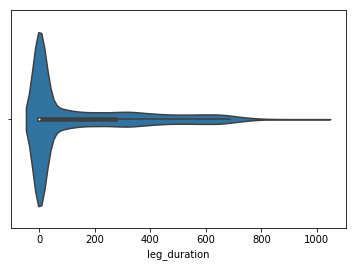

In [41]:
sns.violinplot(x=user_trips.toPandas()["leg_duration"])

In [42]:
user_trips.filter('leg_duration > 0').approxQuantile("leg_duration", [0.5], 0)

[281.0833333333333]

In [43]:
user_trips.write.csv(exp_data_folder_path + '/user_trips', header=True, mode='overwrite')

### Infer Destination Stops

In [58]:
user_trips_data = user_trips \
                .orderBy(['cardNum','o_date','o_timestamp'])
                #.withColumn('o_date',F.from_unixtime(F.col('o_date'), 'yyyy-MM-dd')) \
                #.withColumn('next_o_date',F.from_unixtime(F.col('next_o_date'), 'yyyy-MM-dd')) \

In [32]:
#printdf(user_trips_data)

### Using BUSTE Data as a basis to infer trips destination locations

In [33]:
bus_trip_data = clean_buste_data.orderBy(['route','busCode','tripNum','timestamp']) \
                            .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                            .drop('cardNum') \
                            .withColumn('id',F.monotonically_increasing_id()) \
                            .withColumn('route', F.col('route').cast(T.IntegerType())) \
                            .withColumnRenamed('','cardNum')

In [59]:
user_trips_data.printSchema()

root
 |-- o_route: integer (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: long (nullable = true)
 |-- o_tripNum: integer (nullable = true)
 |-- o_timestamp: string (nullable = true)
 |-- o_shape_id: integer (nullable = true)
 |-- o_shape_seq: integer (nullable = true)
 |-- o_shape_lat: double (nullable = true)
 |-- o_shape_lon: double (nullable = true)
 |-- o_stop_id: integer (nullable = true)
 |-- o_boarding_id: long (nullable = false)
 |-- cardNum: integer (nullable = true)
 |-- next_o_route: integer (nullable = true)
 |-- next_o_bus_code: string (nullable = true)
 |-- next_o_date: long (nullable = true)
 |-- next_o_tripNum: integer (nullable = true)
 |-- next_o_timestamp: string (nullable = true)
 |-- next_o_shape_id: integer (nullable = true)
 |-- next_o_shape_seq: integer (nullable = true)
 |-- next_o_shape_lat: double (nullable = true)
 |-- next_o_shape_lon: double (nullable = true)
 |-- next_o_stop_id: integer (nullable = true)
 |-- next_o_boarding_id: 

In [35]:
bus_trip_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: long (nullable = true)
 |-- id: long (nullable = false)



In [60]:
cond = [bus_trip_data.route == user_trips_data.o_route, 
        bus_trip_data.busCode == user_trips_data.o_bus_code, 
        bus_trip_data.date == user_trips_data.o_date,
        bus_trip_data.tripNum == user_trips_data.o_tripNum]
od_trips = bus_trip_data.join(user_trips_data, cond, 'left_outer')

In [108]:
od_trips.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: long (nullable = true)
 |-- id: long (nullable = false)
 |-- o_route: integer (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: long (nullable = true)
 |-- o_tripNum: 

In [61]:
#printdf(od_trips.orderBy(['route','busCode','tripNum','timestamp']))

In [62]:
print od_trips.count()

1630986


In [63]:
trips_with_boardings = od_trips
#printdf(trips_with_boardings,l=100)

In [64]:
def dist(lat_x, long_x, lat_y, long_y):
    return F.acos(
        F.sin(F.toRadians(lat_x)) * F.sin(F.toRadians(lat_y)) + 
        F.cos(F.toRadians(lat_x)) * F.cos(F.toRadians(lat_y)) * 
            F.cos(F.toRadians(long_x) - F.toRadians(long_y))
    ) * F.lit(6371.0)

In [65]:
trips_with_boardings = trips_with_boardings.withColumn('dist',dist(F.col('shapeLat'),F.col('shapeLon'),F.col('next_o_shape_lat'),F.col('next_o_shape_lon')))

In [66]:
printdf(trips_with_boardings,l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration,dist
0,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,2101,3834486,-25.512700,-49.330343,35107,652835029001,39608,38433,-1.000000,0.010084
1,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,2251,6065662,-25.432839,-49.282980,33808,309237645326,39669,54685,250.266667,10.064292
2,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,2247,5386289,-25.436733,-49.306109,35081,515396075662,40133,78068,632.250000,8.783225
3,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,1731,5095474,-25.394006,-49.301499,26751,1348619730990,51074,63210,202.266667,13.505361
4,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,2899,6191492,-25.418619,-49.293439,33679,1133871366173,48864,75514,444.166667,11.090317
5,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,4223,6560785,-25.478344,-49.356613,35652,962072674443,39499,31454,-1.000000,4.642567
6,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,1737,5197546,-25.389097,-49.294779,27238,1632087572494,51605,78711,451.766667,14.193252
7,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,1821,6412625,-25.413798,-49.265978,30149,1700807049310,43730,69627,431.616667,12.746534
8,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,2161,6355133,-25.434807,-49.272409,26141,910533066888,48766,11295,-1.000000,10.423590
9,40,2,1717,3367172,-25.512655,-49.330256,18405.137,JB606,None,-25.512555,...,1776,6633394,-25.402759,-49.213098,29777,523986010240,51252,75240,399.800000,16.961151


In [67]:
w = Window().partitionBy(['cardNum','date','route','busCode','tripNum']).orderBy('dist')

od_matrix = trips_with_boardings.filter('timestamp > o_timestamp') \
                    .withColumn('rn', F.row_number().over(w)) \
                    .where(F.col('rn') == 1)

In [68]:
# printdf(od_matrix.select(['cardNum','route','tripNum','o_stop_id','o_timestamp','stopPointId','timestamp','dist']) \
#                     .orderBy(['cardNum','o_timestamp']), l=100)

In [69]:
printdf(od_matrix.select(['cardNum','o_stop_id','o_timestamp','stopPointId','timestamp','shapeLat','shapeLon','next_o_shape_lat','next_o_shape_lon','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,o_stop_id,o_timestamp,stopPointId,timestamp,shapeLat,shapeLon,next_o_shape_lat,next_o_shape_lon,dist
0,306135,29384,07:47:59,26351,08:38:58,-25.428586,-49.271164,-25.402933,-49.270782,2.852814
1,306135,33672,17:03:43,33717,17:04:00,-25.423875,-49.279882,-25.443482,-49.270235,2.385665
2,312823,34365,13:26:30,34358,13:31:32,-25.394181,-49.349038,-25.416137,-49.224098,12.784462
3,312823,44998,18:22:30,9385,18:56:05,-25.459064,-49.302164,-25.418532,-49.293509,4.590071
4,313992,33744,15:37:32,33342,15:58:14,-25.399839,-49.333403,-25.414164,-49.211287,12.368376
5,313992,35254,18:40:40,32965,18:45:44,-25.444387,-49.344193,-25.494636,-49.285328,8.132562
6,321469,32251,12:08:04,34897,13:10:20,-25.395316,-49.239433,-25.414648,-49.353608,11.667657
7,321469,33073,14:15:11,33062,14:34:39,-25.439346,-49.310067,-25.419682,-49.348361,4.423698
8,321916,33038,16:21:54,28136,17:54:06,-25.435870,-49.307411,-25.459817,-49.319788,2.938512
9,321916,30170,18:52:42,28592,19:01:08,-25.434322,-49.274532,-25.434736,-49.272225,0.236149


In [59]:
printdf(od_matrix.describe('dist'))

,summary,dist
0,count,54230
1,mean,6.71390882852522
2,stddev,4.4788440291974965
3,min,0.0
4,max,30.172753958356612


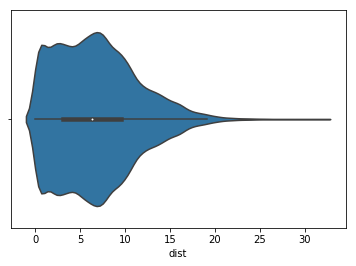

In [60]:
sns.violinplot(x=od_matrix.toPandas()["dist"])

In [61]:
inference_ok = 100*(od_matrix.filter('dist <= 1.0').count()/float(od_matrix.count()))
print "Percentage of trips with destionation satisfying threshold: ", inference_ok, "%"

Percentage of trips with destionation satisfying threshold:  9.47814862622 %


In [62]:
print od_matrix.count()

54230


In [70]:
filtered_od_matrix = od_matrix.filter('dist <= 1.0')

In [71]:
printdf(filtered_od_matrix.select(['cardNum','o_stop_id','o_timestamp','stopPointId','timestamp','shapeLat','shapeLon','next_o_shape_lat','next_o_shape_lon','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,o_stop_id,o_timestamp,stopPointId,timestamp,shapeLat,shapeLon,next_o_shape_lat,next_o_shape_lon,dist
0,321916,30170,18:52:42,28592,19:01:08,-25.434322,-49.274532,-25.434736,-49.272225,0.236149
1,324908,29946,06:49:40,29945,07:28:00,-25.428663,-49.271178,-25.436330,-49.272499,0.862695
2,347297,32850,07:14:13,33179,19:48:15,-25.442021,-49.285502,-25.437674,-49.278226,0.876039
3,352286,32402,09:19:18,26143,09:39:37,-25.434979,-49.272851,-25.434807,-49.272409,0.048309
4,352286,32904,19:07:13,26149,19:09:50,-25.435150,-49.273297,-25.439771,-49.273188,0.514017
5,378013,30162,09:50:37,30632,14:34:46,-25.439295,-49.275202,-25.440780,-49.271526,0.404361
6,386539,26721,07:54:47,37568,09:04:30,-25.427546,-49.280387,-25.424080,-49.274163,0.734391
7,386539,30206,09:50:43,26342,09:53:39,-25.432806,-49.270301,-25.430097,-49.272391,0.367131
8,391190,10070,15:15:27,33858,15:26:17,-25.440083,-49.281736,-25.447405,-49.278309,0.883939
9,405013,35572,07:44:48,33962,18:57:38,-25.401105,-49.334489,-25.399990,-49.336569,0.243020


In [72]:
print filtered_od_matrix.count()

3313


In [84]:
filtered_od_matrix.write.csv(path=exp_data_folder_path+'/od_matrix',header=True, mode='overwrite')

### Enriching BUSTE output with bus crowdedness information

In [73]:
trips_origins = filtered_od_matrix.filter(filtered_od_matrix.cardNum.isNotNull()) \
                            .select(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id','o_timestamp']) \
                            .groupBy(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id']) \
                            .count() \
                            .withColumnRenamed('count','boarding_cnt') \
                            .orderBy(['o_date','o_route','o_bus_code','o_tripNum'])

In [74]:
#printdf(trips_origins, l=20)

In [75]:
trips_destinations = filtered_od_matrix.filter(filtered_od_matrix.cardNum.isNotNull()) \
                            .select(['date','route','busCode','tripNum','stopPointId','timestamp']) \
                            .groupBy(['date','route','busCode','tripNum','stopPointId']) \
                            .count() \
                            .orderBy(['date','route','busCode','tripNum'])

In [76]:
trips_destinations = rename_columns(
                        trips_destinations,
                        [('date','d_date'),
                         ('route','d_route'),
                         ('busCode','d_bus_code'),
                         ('tripNum','d_tripNum'),
                         ('stopPointId','d_stop_id'),
                         ('count','alighting_cnt')])

In [88]:
printdf(trips_destinations, l=20)

,d_date,d_route,d_bus_code,d_tripNum,d_stop_id,alighting_cnt
0,1497927600,10,BB302,1,33156,1
1,1497927600,10,BB302,5,33156,1
2,1497927600,10,BB302,8,33156,1
3,1497927600,10,BB302,12,33166,1
4,1497927600,10,BB303,5,33155,1
5,1497927600,10,BB303,5,26455,1
6,1497927600,10,BB303,5,33175,1
7,1497927600,10,BB303,5,33176,1
8,1497927600,10,BB303,6,33154,1
9,1497927600,10,BB303,12,31747,1


In [109]:
trips_origins2 = trips_origins.withColumnRenamed('o_date','date') \
                    .withColumnRenamed('o_route','route') \
                    .withColumnRenamed('o_bus_code','busCode') \
                    .withColumnRenamed('o_tripNum','tripNum') \
                    .withColumnRenamed('o_stop_id','stopPointId')
                
trips_destinations2 = trips_destinations.withColumnRenamed('d_date','date') \
                    .withColumnRenamed('d_route','route') \
                    .withColumnRenamed('d_bus_code','busCode') \
                    .withColumnRenamed('d_tripNum','tripNum') \
                    .withColumnRenamed('d_stop_id','stopPointId')


#trips_passengers = trips_origins2.join(trips_destinations2, on = ['date','route','busCode','tripNum','stopPointId'], how='outer')

In [112]:
trips_origins2.write.csv(path=exp_data_folder_path+'/trips_origins',header=True, mode='overwrite')

In [113]:
trips_destinations2.write.csv(path=exp_data_folder_path+'/trips_destinations',header=True, mode='overwrite')

In [114]:
trips_o = sqlContext.read.csv(exp_data_folder_path+'/trips_origins', header=True,inferSchema=True,nullValue="-")

In [116]:
printdf(trips_o)

,date,route,busCode,tripNum,stopPointId,boarding_cnt
0,1497927600,916,MA007,6,33433,1
1,1497927600,916,MA007,34,33342,1
2,1497927600,917,MA008,18,33466,1
3,1497927600,917,MA012,10,33649,1
4,1497927600,917,MA299,5,33342,1
5,1497927600,917,MA299,10,33464,1
6,1497927600,917,MA299,20,33344,1
7,1497927600,917,MA299,43,33124,1
8,1497927600,918,MA855,41,33743,1
9,1497927600,924,BA012,1,38135,3


In [115]:
trips_d = sqlContext.read.csv(exp_data_folder_path+'/trips_destinations', header=True,inferSchema=True,nullValue="-")

In [117]:
printdf(trips_d)

,date,route,busCode,tripNum,stopPointId,alighting_cnt
0,1497927600,160,BC027,3,26904,1
1,1497927600,160,BC027,3,26635,1
2,1497927600,160,BC027,6,26571,1
3,1497927600,160,BC027,6,37567,1
4,1497927600,160,BC027,6,26563,1
5,1497927600,160,BC027,7,26627,1
6,1497927600,160,BC027,7,26595,1
7,1497927600,160,BC027,9,33077,1
8,1497927600,160,BC027,9,26563,1
9,1497927600,160,BC027,9,26630,1


In [118]:
trips_passengers = trips_o.join(trips_d, on = ['date','route','busCode','tripNum','stopPointId'], how='outer')

In [119]:
printdf(trips_passengers, l=30)

,date,route,busCode,tripNum,stopPointId,boarding_cnt,alighting_cnt
0,1497927600,20,BB612,1,30195,1.0,NaN
1,1497927600,20,BB612,1,30195,1.0,NaN
2,1497927600,20,JB600,7,27948,1.0,NaN
3,1497927600,20,JB600,7,27948,1.0,NaN
4,1497927600,40,JB606,2,34133,NaN,1.0
5,1497927600,40,MB604,4,35939,3.0,NaN
6,1497927600,40,MB604,4,35939,3.0,NaN
7,1497927600,165,BC931,17,26550,NaN,1.0
8,1497927600,170,BC598,4,27256,NaN,1.0
9,1497927600,175,BC288,29,36934,1.0,NaN


In [123]:
printdf(trips_passengers.describe())

,summary,date,route,busCode,tripNum,stopPointId,boarding_cnt,alighting_cnt
0,count,7197,7197,7197,7197,7197,4364,3003
1,mean,1.4979276E9,509.6709740169515,None,11.784632485757955,30846.721272752537,1.5183318056828599,1.1411921411921413
2,stddev,0.0,327.7694960377818,None,9.44330218386341,5047.227395291072,1.134697837764165,0.4985436926714739
3,min,1497927600,10,BA002,1,276,1,1
4,max,1497927600,972,MN611,60,48603,16,10


In [120]:
buste_crowdedness = bus_trip_data.join(trips_passengers, on=['date','route','busCode','tripNum','stopPointId'], how='left_outer')

In [121]:
printdf(buste_crowdedness)

,date,route,busCode,tripNum,stopPointId,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,...,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,id,boarding_cnt,alighting_cnt
0,1497927600,10,BB302,4,33163,1708,5859465,-25.415752,-49.259505,3322.749,...,9.785197,16:50:50,NO_PROBLEM,None,None,None,None,944892805120,NaN,None
1,1497927600,10,BB302,8,33163,1708,5859465,-25.415752,-49.259505,3322.749,...,NaN,07:37:44,BETWEEN,28/11/75,07:43:56,INTERBAIRROS I H,M,1520418422787,NaN,None
2,1497927600,10,BB303,12,33179,3256,5860055,-25.442021,-49.285502,4532.300,...,NaN,16:51:01,BETWEEN,None,None,None,None,1065151889409,NaN,None
3,1497927600,10,BB303,16,33155,3256,5860191,-25.417244,-49.280636,8648.880,...,NaN,07:23:33,BETWEEN,15/10/90,07:29:23,INTERBAIRROS I H,M,188978561027,NaN,None
4,1497927600,10,BB303,21,26900,3256,5860167,-25.422461,-49.284108,7806.919,...,NaN,21:56:36,BETWEEN,None,None,None,None,1374389534723,NaN,None
5,1497927600,10,BB310,5,32842,1708,5859640,-25.446457,-49.255055,8356.486,...,20.311773,06:15:45,NO_PROBLEM,28/04/81,06:16:42,INTERBAIRROS I H,M,395136991237,NaN,None
6,1497927600,11,BB307,8,31748,1709,5960323,-25.450731,-49.254026,11702.938,...,NaN,16:43:12,BETWEEN,None,None,None,None,1073741824012,NaN,None
7,1497927600,11,BB307,10,32786,1709,5960031,-25.414703,-49.270024,274.126,...,NaN,07:08:38,BETWEEN,None,None,None,None,369367187462,NaN,None
8,1497927600,11,BB307,15,32796,1709,5960143,-25.422675,-49.290025,3636.577,...,NaN,17:42:09,BETWEEN,05/03/94,17:42:27,INTERBAIRROS I A,F,498216206351,1.0,None
9,1497927600,11,BB307,15,32796,1709,5960143,-25.422675,-49.290025,3636.577,...,NaN,17:42:09,BETWEEN,05/03/94,17:42:27,INTERBAIRROS I A,F,498216206351,1.0,None


In [96]:
trips_origins2 = trips_origins.withColumnRenamed('o_date','date') \
                    .withColumnRenamed('o_route','route') \
                    .withColumnRenamed('o_bus_code','busCode') \
                    .withColumnRenamed('o_tripNum','tripNum') \
                    .withColumnRenamed('o_stop_id','stopPointId')

In [98]:
trips_destinations2 = trips_destinations.withColumnRenamed('d_date','date') \
                    .withColumnRenamed('d_route','route') \
                    .withColumnRenamed('d_bus_code','busCode') \
                    .withColumnRenamed('d_tripNum','tripNum') \
                    .withColumnRenamed('d_stop_id','stopPointId')

In [101]:
bus_trip_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: long (nullable = true)
 |-- id: long (nullable = false)



In [102]:
trips_origins2.printSchema()

root
 |-- date: long (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- boarding_cnt: long (nullable = false)



In [105]:
buste_crowdedness_o = bus_trip_data.join(trips_origins2,['date','route','busCode','tripNum','stopPointId'],'left_outer') #\
                        #.join(trips_destinations2,['date','route','busCode','tripNum','stopPointId'],'left_outer')

In [106]:
buste_crowdedness_d = buste_crowdedness_o.join(trips_destinations2,['date','route','busCode','tripNum','stopPointId'],'left_outer')

In [107]:
printdf(buste_crowdedness_d)

Py4JJavaError: An error occurred while calling o1252.collectToPython.
: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange hashpartitioning(date#64L, route#0, busCode#7, tripNum#1, stopPointId#13, 200)
+- *!Project [date#64L, route#0, busCode#7, tripNum#1, stopPointId#13, shapeId#2, shapeSequence#3, shapeLat#4, shapeLon#5, distanceTraveledShape#6, gpsPointId#8, gpsLat#9, gpsLon#10, distanceToShapePoint#11, timestamp#12, problem#14, birthdate#15, cardTimestamp#16, lineName#17, gender#19, id#1223L, boarding_cnt#6456L]
   +- !SortMergeJoin [date#64L, busCode#7, tripNum#1, stopPointId#13], [date#10053L, busCode#10069, tripNum#10077, stopPointId#10085], LeftOuter, (route#0 = route#10061)
      :- *Sort [date#64L ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(date#64L, busCode#7, tripNum#1, stopPointId#13, 200)
      :     +- *Project [tripNum#1, shapeId#2, shapeSequence#3, shapeLat#4, shapeLon#5, distanceTraveledShape#6, busCode#7, gpsPointId#8, gpsLat#9, gpsLon#10, distanceToShapePoint#11, timestamp#12, stopPointId#13, problem#14, birthdate#15, cardTimestamp#16, lineName#17, gender#19, 1497927600 AS date#64L, id#1223L]
      :        +- *Project [tripNum#1, shapeId#2, shapeSequence#3, shapeLat#4, shapeLon#5, distanceTraveledShape#6, busCode#7, gpsPointId#8, gpsLat#9, gpsLon#10, distanceToShapePoint#11, timestamp#12, stopPointId#13, problem#14, birthdate#15, cardTimestamp#16, lineName#17, gender#19, monotonically_increasing_id() AS id#1223L]
      :           +- SortAggregate(key=[route#0, busCode#7, tripNum#1, stopPointId#13], functions=[first(shapeId#2, false), first(shapeSequence#3, false), first(shapeLat#4, false), first(shapeLon#5, false), first(distanceTraveledShape#6, false), first(gpsPointId#8, false), first(gpsLat#9, false), first(gpsLon#10, false), first(distanceToShapePoint#11, false), first(timestamp#12, false), first(problem#14, false), first(birthdate#15, false), first(cardTimestamp#16, false), first(lineName#17, false), first(gender#19, false)], output=[tripNum#1, shapeId#2, shapeSequence#3, shapeLat#4, shapeLon#5, distanceTraveledShape#6, busCode#7, gpsPointId#8, gpsLat#9, gpsLon#10, distanceToShapePoint#11, timestamp#12, stopPointId#13, problem#14, birthdate#15, cardTimestamp#16, lineName#17, gender#19])
      :              +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
      :                 +- Exchange hashpartitioning(route#0, busCode#7, tripNum#1, stopPointId#13, 200)
      :                    +- SortAggregate(key=[route#0, busCode#7, tripNum#1, stopPointId#13], functions=[partial_first(shapeId#2, false), partial_first(shapeSequence#3, false), partial_first(shapeLat#4, false), partial_first(shapeLon#5, false), partial_first(distanceTraveledShape#6, false), partial_first(gpsPointId#8, false), partial_first(gpsLat#9, false), partial_first(gpsLon#10, false), partial_first(distanceToShapePoint#11, false), partial_first(timestamp#12, false), partial_first(problem#14, false), partial_first(birthdate#15, false), partial_first(cardTimestamp#16, false), partial_first(lineName#17, false), partial_first(gender#19, false)], output=[route#0, busCode#7, tripNum#1, stopPointId#13, first#3273, valueSet#3274, first#3275, valueSet#3276, first#1705, valueSet#1706, first#1707, valueSet#1708, first#3277, valueSet#3278, first#3279, valueSet#3280, first#3281, valueSet#3282, first#3283, valueSet#3284, first#3285, valueSet#3286, first#1709, valueSet#1710, ... 10 more fields])
      :                       +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
      :                          +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, timestamp#12 ASC NULLS FIRST], true, 0
      :                             +- Exchange rangepartitioning(route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, timestamp#12 ASC NULLS FIRST, 200)
      :                                +- *Filter AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4)
      :                                   +- *FileScan csv [route#0,tripNum#1,shapeId#2,shapeSequence#3,shapeLat#4,shapeLon#5,distanceTraveledShape#6,busCode#7,gpsPointId#8,gpsLat#9,gpsLon#10,distanceToShapePoint#11,timestamp#12,stopPointId#13,problem#14,birthdate#15,cardTimestamp#16,lineName#17,gender#19] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<route:int,tripNum:int,shapeId:int,shapeSequence:int,shapeLat:double,shapeLon:double,distan...
      +- *Sort [date#10053L ASC NULLS FIRST, busCode#10069 ASC NULLS FIRST, tripNum#10077 ASC NULLS FIRST, stopPointId#10085 ASC NULLS FIRST], false, 0
         +- Exchange hashpartitioning(date#10053L, busCode#10069, tripNum#10077, stopPointId#10085, 200)
            +- *Project [o_date#342L AS date#10053L, o_route#340 AS route#10061, o_bus_code#341 AS busCode#10069, o_tripNum#343 AS tripNum#10077, o_stop_id#349 AS stopPointId#10085, boarding_cnt#6456L]
               +- *Sort [o_date#342L ASC NULLS FIRST, o_route#340 ASC NULLS FIRST, o_bus_code#341 ASC NULLS FIRST, o_tripNum#343 ASC NULLS FIRST], true, 0
                  +- Exchange rangepartitioning(o_date#342L ASC NULLS FIRST, o_route#340 ASC NULLS FIRST, o_bus_code#341 ASC NULLS FIRST, o_tripNum#343 ASC NULLS FIRST, 200)
                     +- *HashAggregate(keys=[o_date#342L, o_route#340, o_bus_code#341, o_tripNum#343, o_stop_id#349], functions=[count(1)], output=[o_date#342L, o_route#340, o_bus_code#341, o_tripNum#343, o_stop_id#349, boarding_cnt#6456L])
                        +- *HashAggregate(keys=[o_date#342L, o_route#340, o_bus_code#341, o_tripNum#343, o_stop_id#349], functions=[partial_count(1)], output=[o_date#342L, o_route#340, o_bus_code#341, o_tripNum#343, o_stop_id#349, count#6832L])
                           +- *Project [o_date#342L, o_route#340, o_bus_code#341, o_tripNum#343, o_stop_id#349]
                              +- *Filter (((isnotnull(rn#4935) && (rn#4935 = 1)) && isnotnull(dist#4412)) && (dist#4412 <= 1.0))
                                 +- Window [row_number() windowspecdefinition(cardNum#18, date#64L, route#0, busCode#7, tripNum#1, dist#4412 ASC NULLS FIRST, ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS rn#4935], [cardNum#18, date#64L, route#0, busCode#7, tripNum#1], [dist#4412 ASC NULLS FIRST]
                                    +- *Sort [cardNum#18 ASC NULLS FIRST, date#64L ASC NULLS FIRST, route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, dist#4412 ASC NULLS FIRST], false, 0
                                       +- *!Project [route#0, tripNum#1, busCode#7, date#64L, o_route#340, o_bus_code#341, o_date#342L, o_tripNum#343, o_stop_id#349, cardNum#18, (ACOS(((SIN(RADIANS(shapeLat#4)) * SIN(RADIANS(next_o_shape_lat#370))) + ((COS(RADIANS(shapeLat#4)) * COS(RADIANS(next_o_shape_lat#370))) * COS((RADIANS(shapeLon#5) - RADIANS(next_o_shape_lon#371)))))) * 6371.0) AS dist#4412]
                                          +- *!SortMergeJoin [busCode#7, tripNum#1], [o_bus_code#341, o_tripNum#343], Inner, ((timestamp#12 > o_timestamp#344) && (route#0 = o_route#340))
                                             :- *Sort [busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST], false, 0
                                             :  +- Exchange hashpartitioning(busCode#7, tripNum#1, 200)
                                             :     +- *Project [tripNum#1, shapeLat#4, shapeLon#5, busCode#7, timestamp#12, 1497927600 AS date#64L]
                                             :        +- SortAggregate(key=[route#0, busCode#7, tripNum#1, stopPointId#13], functions=[first(shapeLat#4, false), first(shapeLon#5, false), first(timestamp#12, false)], output=[tripNum#1, shapeLat#4, shapeLon#5, busCode#7, timestamp#12])
                                             :           +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
                                             :              +- Exchange hashpartitioning(route#0, busCode#7, tripNum#1, stopPointId#13, 200)
                                             :                 +- SortAggregate(key=[route#0, busCode#7, tripNum#1, stopPointId#13], functions=[partial_first(shapeLat#4, false), partial_first(shapeLon#5, false), partial_first(timestamp#12, false)], output=[route#0, busCode#7, tripNum#1, stopPointId#13, first#1705, valueSet#1706, first#1707, valueSet#1708, first#1709, valueSet#1710])
                                             :                    +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
                                             :                       +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, timestamp#12 ASC NULLS FIRST], true, 0
                                             :                          +- Exchange rangepartitioning(route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, timestamp#12 ASC NULLS FIRST, 200)
                                             :                             +- *Project [route#0, tripNum#1, shapeLat#4, shapeLon#5, busCode#7, timestamp#12, stopPointId#13]
                                             :                                +- *Filter ((((AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && isnotnull(timestamp#12)) && isnotnull(route#0)) && isnotnull(busCode#7)) && isnotnull(tripNum#1))
                                             :                                   +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [IsNotNull(timestamp), IsNotNull(route), IsNotNull(busCode), IsNotNull(tripNum)], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                             +- *Sort [o_bus_code#341 ASC NULLS FIRST, o_tripNum#343 ASC NULLS FIRST], false, 0
                                                +- Exchange hashpartitioning(o_bus_code#341, o_tripNum#343, 200)
                                                   +- *Sort [cardNum#18 ASC NULLS FIRST, o_date#342L ASC NULLS FIRST, o_timestamp#344 ASC NULLS FIRST], true, 0
                                                      +- Exchange rangepartitioning(cardNum#18 ASC NULLS FIRST, o_date#342L ASC NULLS FIRST, o_timestamp#344 ASC NULLS FIRST, 200)
                                                         +- *Project [o_route#340, o_bus_code#341, o_date#342L, o_tripNum#343, o_timestamp#344, o_stop_id#349, cardNum#18, next_o_shape_lat#370, next_o_shape_lon#371]
                                                            +- *SortMergeJoin [next_boarding_id#330L], [next_o_boarding_id#373L], Inner
                                                               :- *Sort [next_boarding_id#330L ASC NULLS FIRST], false, 0
                                                               :  +- Exchange hashpartitioning(next_boarding_id#330L, 200)
                                                               :     +- *Project [o_route#340, o_bus_code#341, o_date#342L, o_tripNum#343, o_timestamp#344, o_stop_id#349, cardNum#18, next_boarding_id#330L]
                                                               :        +- *BroadcastHashJoin [o_boarding_id#350L], [boarding_id#298L], Inner, BuildRight
                                                               :           :- *Project [route#0 AS o_route#340, busCode#7 AS o_bus_code#341, date#64L AS o_date#342L, tripNum#1 AS o_tripNum#343, cardTimestamp#16 AS o_timestamp#344, stopPointId#13 AS o_stop_id#349, boarding_id#298L AS o_boarding_id#350L]
                                                               :           :  +- *Filter ((((isnotnull(cardTimestamp#16) && isnotnull(tripNum#1)) && isnotnull(route#0)) && isnotnull(busCode#7)) && (1497927600 = date#64L))
                                                               :           :     +- *Project [route#0, tripNum#1, busCode#7, stopPointId#13, cardTimestamp#16, date#64L, monotonically_increasing_id() AS boarding_id#298L]
                                                               :           :        +- *BroadcastHashJoin [cardNum#18], [cardNum1#224], LeftSemi, BuildRight
                                                               :           :           :- *Project [route#0, tripNum#1, busCode#7, stopPointId#13, cardTimestamp#16, cardNum#18, 1497927600 AS date#64L]
                                                               :           :           :  +- SortAggregate(key=[cardNum#18, 1497927600#11178L, cardTimestamp#16], functions=[first(route#0, false), first(tripNum#1, false), first(busCode#7, false), first(stopPointId#13, false)], output=[route#0, tripNum#1, busCode#7, stopPointId#13, cardTimestamp#16, cardNum#18])
                                                               :           :           :     +- *Sort [cardNum#18 ASC NULLS FIRST, 1497927600#11178L ASC NULLS FIRST, cardTimestamp#16 ASC NULLS FIRST], false, 0
                                                               :           :           :        +- Exchange hashpartitioning(cardNum#18, 1497927600#11178L, cardTimestamp#16, 200)
                                                               :           :           :           +- SortAggregate(key=[cardNum#18, 1497927600 AS 1497927600#11178L, cardTimestamp#16], functions=[partial_first(route#0, false), partial_first(tripNum#1, false), partial_first(busCode#7, false), partial_first(stopPointId#13, false)], output=[cardNum#18, 1497927600#11178L, cardTimestamp#16, first#660, valueSet#661, first#662, valueSet#663, first#672, valueSet#673, first#674, valueSet#675])
                                                               :           :           :              +- *Sort [cardNum#18 ASC NULLS FIRST, 1497927600 AS 1497927600#11178L ASC NULLS FIRST, cardTimestamp#16 ASC NULLS FIRST], false, 0
                                                               :           :           :                 +- *Project [route#0, tripNum#1, busCode#7, stopPointId#13, cardTimestamp#16, cardNum#18]
                                                               :           :           :                    +- *Filter ((AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16)) && isnotnull(cardNum#18))
                                                               :           :           :                       +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [IsNotNull(cardNum)], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                               :           :           +- BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, true] as bigint)))
                                                               :           :              +- *Project [cardNum#18 AS cardNum1#224]
                                                               :           :                 +- *Filter (count#175L > 1)
                                                               :           :                    +- *HashAggregate(keys=[cardNum#18], functions=[count(1)], output=[cardNum#18, count#175L])
                                                               :           :                       +- Exchange hashpartitioning(cardNum#18, 200)
                                                               :           :                          +- *HashAggregate(keys=[cardNum#18], functions=[partial_count(1)], output=[cardNum#18, count#213L])
                                                               :           :                             +- *HashAggregate(keys=[cardNum#18, 1497927600#11179L, cardTimestamp#16], functions=[], output=[cardNum#18])
                                                               :           :                                +- Exchange hashpartitioning(cardNum#18, 1497927600#11179L, cardTimestamp#16, 200)
                                                               :           :                                   +- *HashAggregate(keys=[cardNum#18, 1497927600 AS 1497927600#11179L, cardTimestamp#16], functions=[], output=[cardNum#18, 1497927600#11179L, cardTimestamp#16])
                                                               :           :                                      +- *Project [cardTimestamp#16, cardNum#18]
                                                               :           :                                         +- *Filter (AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16))
                                                               :           :                                            +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                               :           +- BroadcastExchange HashedRelationBroadcastMode(List(input[1, bigint, false]))
                                                               :              +- *Project [cardNum#18, boarding_id#298L, CASE WHEN (next_boarding_id#322L = -1) THEN first_boarding#324L ELSE next_boarding_id#322L END AS next_boarding_id#330L]
                                                               :                 +- *Filter isnotnull(CASE WHEN (next_boarding_id#322L = -1) THEN first_boarding#324L ELSE next_boarding_id#322L END)
                                                               :                    +- Window [lead(boarding_id#298L, 1, -1) windowspecdefinition(cardNum#18, date#64L, cardTimestamp#16 ASC NULLS FIRST, ROWS BETWEEN 1 FOLLOWING AND 1 FOLLOWING) AS next_boarding_id#322L, first(boarding_id#298L, true) windowspecdefinition(cardNum#18, date#64L, cardTimestamp#16 ASC NULLS FIRST, RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS first_boarding#324L], [cardNum#18, date#64L], [cardTimestamp#16 ASC NULLS FIRST]
                                                               :                       +- *Sort [cardNum#18 ASC NULLS FIRST, date#64L ASC NULLS FIRST, cardTimestamp#16 ASC NULLS FIRST], false, 0
                                                               :                          +- Exchange hashpartitioning(cardNum#18, date#64L, 200)
                                                               :                             +- *Project [cardNum#18, boarding_id#298L, date#64L, cardTimestamp#16]
                                                               :                                +- *Project [cardTimestamp#16, cardNum#18, date#64L, monotonically_increasing_id() AS boarding_id#298L]
                                                               :                                   +- *BroadcastHashJoin [cardNum#18], [cardNum1#224], LeftSemi, BuildRight
                                                               :                                      :- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[], output=[cardTimestamp#16, cardNum#18, date#64L])
                                                               :                                      :  +- Exchange hashpartitioning(cardNum#18, date#64L, cardTimestamp#16, 200)
                                                               :                                      :     +- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[], output=[cardNum#18, date#64L, cardTimestamp#16])
                                                               :                                      :        +- *Project [cardTimestamp#16, cardNum#18, 1497927600 AS date#64L]
                                                               :                                      :           +- *Filter ((AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16)) && isnotnull(cardNum#18))
                                                               :                                      :              +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [IsNotNull(cardNum)], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                               :                                      +- BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, true] as bigint)))
                                                               :                                         +- *Project [cardNum#18 AS cardNum1#224]
                                                               :                                            +- *Filter (count#175L > 1)
                                                               :                                               +- *HashAggregate(keys=[cardNum#18], functions=[count(1)], output=[cardNum#18, count#175L])
                                                               :                                                  +- Exchange hashpartitioning(cardNum#18, 200)
                                                               :                                                     +- *HashAggregate(keys=[cardNum#18], functions=[partial_count(1)], output=[cardNum#18, count#213L])
                                                               :                                                        +- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[], output=[cardNum#18])
                                                               :                                                           +- Exchange hashpartitioning(cardNum#18, date#64L, cardTimestamp#16, 200)
                                                               :                                                              +- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[], output=[cardNum#18, date#64L, cardTimestamp#16])
                                                               :                                                                 +- *Project [cardTimestamp#16, cardNum#18, 1497927600 AS date#64L]
                                                               :                                                                    +- *Filter (AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16))
                                                               :                                                                       +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                               +- *Sort [next_o_boarding_id#373L ASC NULLS FIRST], false, 0
                                                                  +- Exchange hashpartitioning(next_o_boarding_id#373L, 200)
                                                                     +- *Project [shapeLat#4 AS next_o_shape_lat#370, shapeLon#5 AS next_o_shape_lon#371, boarding_id#298L AS next_o_boarding_id#373L]
                                                                        +- *Project [shapeLat#4, shapeLon#5, monotonically_increasing_id() AS boarding_id#298L]
                                                                           +- *BroadcastHashJoin [cardNum#18], [cardNum1#224], LeftSemi, BuildRight
                                                                              :- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[first(shapeLat#4, false), first(shapeLon#5, false)], output=[shapeLat#4, shapeLon#5, cardNum#18])
                                                                              :  +- Exchange hashpartitioning(cardNum#18, date#64L, cardTimestamp#16, 200)
                                                                              :     +- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[partial_first(shapeLat#4, false), partial_first(shapeLon#5, false)], output=[cardNum#18, date#64L, cardTimestamp#16, first#668, valueSet#669, first#670, valueSet#671])
                                                                              :        +- *Project [shapeLat#4, shapeLon#5, cardTimestamp#16, cardNum#18, 1497927600 AS date#64L]
                                                                              :           +- *Filter ((AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16)) && isnotnull(cardNum#18))
                                                                              :              +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [IsNotNull(cardNum)], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                                              +- ReusedExchange [cardNum1#224], BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, true] as bigint)))

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange.doExecute(ShuffleExchange.scala:112)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:235)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:121)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:368)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.joins.SortMergeJoinExec.doExecute(SortMergeJoinExec.scala:101)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:235)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:42)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:368)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:225)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:308)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2745)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2742)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2742)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2765)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2742)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: Binding attribute, tree: route#0
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:88)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:87)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$3.apply(TreeNode.scala:288)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$3.apply(TreeNode.scala:288)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:70)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:287)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transform(TreeNode.scala:277)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$.bindReference(BoundAttribute.scala:87)
	at org.apache.spark.sql.execution.ProjectExec$$anonfun$4.apply(basicPhysicalOperators.scala:61)
	at org.apache.spark.sql.execution.ProjectExec$$anonfun$4.apply(basicPhysicalOperators.scala:60)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.AbstractTraversable.map(Traversable.scala:104)
	at org.apache.spark.sql.execution.ProjectExec.doConsume(basicPhysicalOperators.scala:60)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:153)
	at org.apache.spark.sql.execution.InputAdapter.consume(WholeStageCodegenExec.scala:218)
	at org.apache.spark.sql.execution.InputAdapter.doProduce(WholeStageCodegenExec.scala:246)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.InputAdapter.produce(WholeStageCodegenExec.scala:218)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:46)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:36)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doCodeGen(WholeStageCodegenExec.scala:313)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:354)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange.prepareShuffleDependency(ShuffleExchange.scala:85)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$$anonfun$doExecute$1.apply(ShuffleExchange.scala:121)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$$anonfun$doExecute$1.apply(ShuffleExchange.scala:112)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 52 more
Caused by: java.lang.RuntimeException: Couldn't find route#0 in [tripNum#1,shapeId#2,shapeSequence#3,shapeLat#4,shapeLon#5,distanceTraveledShape#6,busCode#7,gpsPointId#8,gpsLat#9,gpsLon#10,distanceToShapePoint#11,timestamp#12,stopPointId#13,problem#14,birthdate#15,cardTimestamp#16,lineName#17,gender#19,date#64L,id#1223L,date#10053L,route#10061,busCode#10069,tripNum#10077,stopPointId#10085,boarding_cnt#6456L]
	at scala.sys.package$.error(package.scala:27)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1$$anonfun$applyOrElse$1.apply(BoundAttribute.scala:94)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1$$anonfun$applyOrElse$1.apply(BoundAttribute.scala:88)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 99 more


In [92]:
origin_cond = [bus_trip_data.date == trips_origins.o_date,
               bus_trip_data.route == trips_origins.o_route, 
               bus_trip_data.busCode == trips_origins.o_bus_code, 
               bus_trip_data.tripNum == trips_origins.o_tripNum,
               bus_trip_data.stopPointId == trips_origins.o_stop_id
]

dest_cond = [bus_trip_data.date == trips_destinations.d_date,
               bus_trip_data.route == trips_destinations.d_route, 
               bus_trip_data.busCode == trips_destinations.d_bus_code, 
               bus_trip_data.tripNum == trips_destinations.d_tripNum,
               bus_trip_data.stopPointId == trips_destinations.d_stop_id
]


buste_crowdedness = bus_trip_data.join(trips_destinations,dest_cond,'left_outer') \
                        .join(trips_origins,origin_cond,'left_outer') \
                        .drop('d_date','d_route','d_bus_code','d_tripNum','d_stop_id') \
                        .drop('o_date','o_route','o_bus_code','o_tripNum','o_stop_id') \
                        .withColumn('alighting_cnt',F.when(F.col('alighting_cnt').isNull(),F.lit(0)).otherwise(F.col('alighting_cnt'))) \
                        .withColumn('boarding_cnt',F.when(F.col('boarding_cnt').isNull(),F.lit(0)).otherwise(F.col('boarding_cnt'))) \
                        

In [93]:
printdf(buste_crowdedness)

Py4JJavaError: An error occurred while calling o1056.collectToPython.
: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange hashpartitioning(date#64L, route#0, busCode#7, tripNum#1, stopPointId#13, 200)
+- *!Project [route#0, tripNum#1, shapeId#2, shapeSequence#3, shapeLat#4, shapeLon#5, distanceTraveledShape#6, busCode#7, gpsPointId#8, gpsLat#9, gpsLon#10, distanceToShapePoint#11, timestamp#12, stopPointId#13, problem#14, birthdate#15, cardTimestamp#16, lineName#17, gender#19, date#64L, id#1223L, alighting_cnt#6530L]
   +- !SortMergeJoin [date#64L, busCode#7, tripNum#1, stopPointId#13], [d_date#6490L, d_bus_code#6506, d_tripNum#6514, d_stop_id#6522], LeftOuter, (route#0 = d_route#6498)
      :- *Sort [date#64L ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(date#64L, busCode#7, tripNum#1, stopPointId#13, 200)
      :     +- *Project [tripNum#1, shapeId#2, shapeSequence#3, shapeLat#4, shapeLon#5, distanceTraveledShape#6, busCode#7, gpsPointId#8, gpsLat#9, gpsLon#10, distanceToShapePoint#11, timestamp#12, stopPointId#13, problem#14, birthdate#15, cardTimestamp#16, lineName#17, gender#19, 1497927600 AS date#64L, id#1223L]
      :        +- *Project [tripNum#1, shapeId#2, shapeSequence#3, shapeLat#4, shapeLon#5, distanceTraveledShape#6, busCode#7, gpsPointId#8, gpsLat#9, gpsLon#10, distanceToShapePoint#11, timestamp#12, stopPointId#13, problem#14, birthdate#15, cardTimestamp#16, lineName#17, gender#19, monotonically_increasing_id() AS id#1223L]
      :           +- SortAggregate(key=[route#0, busCode#7, tripNum#1, stopPointId#13], functions=[first(shapeId#2, false), first(shapeSequence#3, false), first(shapeLat#4, false), first(shapeLon#5, false), first(distanceTraveledShape#6, false), first(gpsPointId#8, false), first(gpsLat#9, false), first(gpsLon#10, false), first(distanceToShapePoint#11, false), first(timestamp#12, false), first(problem#14, false), first(birthdate#15, false), first(cardTimestamp#16, false), first(lineName#17, false), first(gender#19, false)], output=[tripNum#1, shapeId#2, shapeSequence#3, shapeLat#4, shapeLon#5, distanceTraveledShape#6, busCode#7, gpsPointId#8, gpsLat#9, gpsLon#10, distanceToShapePoint#11, timestamp#12, stopPointId#13, problem#14, birthdate#15, cardTimestamp#16, lineName#17, gender#19])
      :              +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
      :                 +- Exchange hashpartitioning(route#0, busCode#7, tripNum#1, stopPointId#13, 200)
      :                    +- SortAggregate(key=[route#0, busCode#7, tripNum#1, stopPointId#13], functions=[partial_first(shapeId#2, false), partial_first(shapeSequence#3, false), partial_first(shapeLat#4, false), partial_first(shapeLon#5, false), partial_first(distanceTraveledShape#6, false), partial_first(gpsPointId#8, false), partial_first(gpsLat#9, false), partial_first(gpsLon#10, false), partial_first(distanceToShapePoint#11, false), partial_first(timestamp#12, false), partial_first(problem#14, false), partial_first(birthdate#15, false), partial_first(cardTimestamp#16, false), partial_first(lineName#17, false), partial_first(gender#19, false)], output=[route#0, busCode#7, tripNum#1, stopPointId#13, first#3273, valueSet#3274, first#3275, valueSet#3276, first#1705, valueSet#1706, first#1707, valueSet#1708, first#3277, valueSet#3278, first#3279, valueSet#3280, first#3281, valueSet#3282, first#3283, valueSet#3284, first#3285, valueSet#3286, first#1709, valueSet#1710, ... 10 more fields])
      :                       +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
      :                          +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, timestamp#12 ASC NULLS FIRST], true, 0
      :                             +- Exchange rangepartitioning(route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, timestamp#12 ASC NULLS FIRST, 200)
      :                                +- *Filter AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4)
      :                                   +- *FileScan csv [route#0,tripNum#1,shapeId#2,shapeSequence#3,shapeLat#4,shapeLon#5,distanceTraveledShape#6,busCode#7,gpsPointId#8,gpsLat#9,gpsLon#10,distanceToShapePoint#11,timestamp#12,stopPointId#13,problem#14,birthdate#15,cardTimestamp#16,lineName#17,gender#19] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<route:int,tripNum:int,shapeId:int,shapeSequence:int,shapeLat:double,shapeLon:double,distan...
      +- *Sort [d_date#6490L ASC NULLS FIRST, d_bus_code#6506 ASC NULLS FIRST, d_tripNum#6514 ASC NULLS FIRST, d_stop_id#6522 ASC NULLS FIRST], false, 0
         +- Exchange hashpartitioning(d_date#6490L, d_bus_code#6506, d_tripNum#6514, d_stop_id#6522, 200)
            +- *Project [date#64L AS d_date#6490L, route#0 AS d_route#6498, busCode#7 AS d_bus_code#6506, tripNum#1 AS d_tripNum#6514, stopPointId#13 AS d_stop_id#6522, count#6481L AS alighting_cnt#6530L]
               +- *Sort [date#64L ASC NULLS FIRST, route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST], true, 0
                  +- Exchange rangepartitioning(date#64L ASC NULLS FIRST, route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, 200)
                     +- *HashAggregate(keys=[date#64L, route#0, busCode#7, tripNum#1, stopPointId#13], functions=[count(1)], output=[date#64L, route#0, busCode#7, tripNum#1, stopPointId#13, count#6481L])
                        +- *HashAggregate(keys=[date#64L, route#0, busCode#7, tripNum#1, stopPointId#13], functions=[partial_count(1)], output=[date#64L, route#0, busCode#7, tripNum#1, stopPointId#13, count#6836L])
                           +- *Project [date#64L, route#0, busCode#7, tripNum#1, stopPointId#13]
                              +- *Filter (((isnotnull(rn#4935) && (rn#4935 = 1)) && isnotnull(dist#4412)) && (dist#4412 <= 1.0))
                                 +- Window [row_number() windowspecdefinition(cardNum#18, date#64L, route#0, busCode#7, tripNum#1, dist#4412 ASC NULLS FIRST, ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS rn#4935], [cardNum#18, date#64L, route#0, busCode#7, tripNum#1], [dist#4412 ASC NULLS FIRST]
                                    +- *Sort [cardNum#18 ASC NULLS FIRST, date#64L ASC NULLS FIRST, route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, dist#4412 ASC NULLS FIRST], false, 0
                                       +- *!Project [route#0, tripNum#1, busCode#7, stopPointId#13, date#64L, cardNum#18, (ACOS(((SIN(RADIANS(shapeLat#4)) * SIN(RADIANS(next_o_shape_lat#370))) + ((COS(RADIANS(shapeLat#4)) * COS(RADIANS(next_o_shape_lat#370))) * COS((RADIANS(shapeLon#5) - RADIANS(next_o_shape_lon#371)))))) * 6371.0) AS dist#4412]
                                          +- *!SortMergeJoin [busCode#7, tripNum#1], [o_bus_code#341, o_tripNum#343], Inner, ((timestamp#12 > o_timestamp#344) && (route#0 = o_route#340))
                                             :- *Sort [busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST], false, 0
                                             :  +- Exchange hashpartitioning(busCode#7, tripNum#1, 200)
                                             :     +- *Project [tripNum#1, shapeLat#4, shapeLon#5, busCode#7, timestamp#12, stopPointId#13, 1497927600 AS date#64L]
                                             :        +- SortAggregate(key=[route#0, busCode#7, tripNum#1, stopPointId#13], functions=[first(shapeLat#4, false), first(shapeLon#5, false), first(timestamp#12, false)], output=[tripNum#1, shapeLat#4, shapeLon#5, busCode#7, timestamp#12, stopPointId#13])
                                             :           +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
                                             :              +- Exchange hashpartitioning(route#0, busCode#7, tripNum#1, stopPointId#13, 200)
                                             :                 +- SortAggregate(key=[route#0, busCode#7, tripNum#1, stopPointId#13], functions=[partial_first(shapeLat#4, false), partial_first(shapeLon#5, false), partial_first(timestamp#12, false)], output=[route#0, busCode#7, tripNum#1, stopPointId#13, first#1705, valueSet#1706, first#1707, valueSet#1708, first#1709, valueSet#1710])
                                             :                    +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, stopPointId#13 ASC NULLS FIRST], false, 0
                                             :                       +- *Sort [route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, timestamp#12 ASC NULLS FIRST], true, 0
                                             :                          +- Exchange rangepartitioning(route#0 ASC NULLS FIRST, busCode#7 ASC NULLS FIRST, tripNum#1 ASC NULLS FIRST, timestamp#12 ASC NULLS FIRST, 200)
                                             :                             +- *Project [route#0, tripNum#1, shapeLat#4, shapeLon#5, busCode#7, timestamp#12, stopPointId#13]
                                             :                                +- *Filter ((((AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && isnotnull(timestamp#12)) && isnotnull(route#0)) && isnotnull(busCode#7)) && isnotnull(tripNum#1))
                                             :                                   +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [IsNotNull(timestamp), IsNotNull(route), IsNotNull(busCode), IsNotNull(tripNum)], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                             +- *Sort [o_bus_code#341 ASC NULLS FIRST, o_tripNum#343 ASC NULLS FIRST], false, 0
                                                +- Exchange hashpartitioning(o_bus_code#341, o_tripNum#343, 200)
                                                   +- *Project [o_route#340, o_bus_code#341, o_tripNum#343, o_timestamp#344, cardNum#18, next_o_shape_lat#370, next_o_shape_lon#371]
                                                      +- *Sort [cardNum#18 ASC NULLS FIRST, o_date#342L ASC NULLS FIRST, o_timestamp#344 ASC NULLS FIRST], true, 0
                                                         +- Exchange rangepartitioning(cardNum#18 ASC NULLS FIRST, o_date#342L ASC NULLS FIRST, o_timestamp#344 ASC NULLS FIRST, 200)
                                                            +- *Project [o_route#340, o_bus_code#341, o_date#342L, o_tripNum#343, o_timestamp#344, cardNum#18, next_o_shape_lat#370, next_o_shape_lon#371]
                                                               +- *SortMergeJoin [next_boarding_id#330L], [next_o_boarding_id#373L], Inner
                                                                  :- *Sort [next_boarding_id#330L ASC NULLS FIRST], false, 0
                                                                  :  +- Exchange hashpartitioning(next_boarding_id#330L, 200)
                                                                  :     +- *Project [o_route#340, o_bus_code#341, o_date#342L, o_tripNum#343, o_timestamp#344, cardNum#18, next_boarding_id#330L]
                                                                  :        +- *BroadcastHashJoin [o_boarding_id#350L], [boarding_id#298L], Inner, BuildRight
                                                                  :           :- *Project [route#0 AS o_route#340, busCode#7 AS o_bus_code#341, date#64L AS o_date#342L, tripNum#1 AS o_tripNum#343, cardTimestamp#16 AS o_timestamp#344, boarding_id#298L AS o_boarding_id#350L]
                                                                  :           :  +- *Filter ((((isnotnull(cardTimestamp#16) && isnotnull(tripNum#1)) && isnotnull(route#0)) && isnotnull(busCode#7)) && (1497927600 = date#64L))
                                                                  :           :     +- *Project [route#0, tripNum#1, busCode#7, cardTimestamp#16, date#64L, monotonically_increasing_id() AS boarding_id#298L]
                                                                  :           :        +- *BroadcastHashJoin [cardNum#18], [cardNum1#224], LeftSemi, BuildRight
                                                                  :           :           :- *Project [route#0, tripNum#1, busCode#7, cardTimestamp#16, cardNum#18, 1497927600 AS date#64L]
                                                                  :           :           :  +- SortAggregate(key=[cardNum#18, 1497927600#9624L, cardTimestamp#16], functions=[first(route#0, false), first(tripNum#1, false), first(busCode#7, false)], output=[route#0, tripNum#1, busCode#7, cardTimestamp#16, cardNum#18])
                                                                  :           :           :     +- *Sort [cardNum#18 ASC NULLS FIRST, 1497927600#9624L ASC NULLS FIRST, cardTimestamp#16 ASC NULLS FIRST], false, 0
                                                                  :           :           :        +- Exchange hashpartitioning(cardNum#18, 1497927600#9624L, cardTimestamp#16, 200)
                                                                  :           :           :           +- SortAggregate(key=[cardNum#18, 1497927600 AS 1497927600#9624L, cardTimestamp#16], functions=[partial_first(route#0, false), partial_first(tripNum#1, false), partial_first(busCode#7, false)], output=[cardNum#18, 1497927600#9624L, cardTimestamp#16, first#660, valueSet#661, first#662, valueSet#663, first#672, valueSet#673])
                                                                  :           :           :              +- *Sort [cardNum#18 ASC NULLS FIRST, 1497927600 AS 1497927600#9624L ASC NULLS FIRST, cardTimestamp#16 ASC NULLS FIRST], false, 0
                                                                  :           :           :                 +- *Project [route#0, tripNum#1, busCode#7, cardTimestamp#16, cardNum#18]
                                                                  :           :           :                    +- *Filter ((AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16)) && isnotnull(cardNum#18))
                                                                  :           :           :                       +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [IsNotNull(cardNum)], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                                  :           :           +- BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, true] as bigint)))
                                                                  :           :              +- *Project [cardNum#18 AS cardNum1#224]
                                                                  :           :                 +- *Filter (count#175L > 1)
                                                                  :           :                    +- *HashAggregate(keys=[cardNum#18], functions=[count(1)], output=[cardNum#18, count#175L])
                                                                  :           :                       +- Exchange hashpartitioning(cardNum#18, 200)
                                                                  :           :                          +- *HashAggregate(keys=[cardNum#18], functions=[partial_count(1)], output=[cardNum#18, count#213L])
                                                                  :           :                             +- *HashAggregate(keys=[cardNum#18, 1497927600#9625L, cardTimestamp#16], functions=[], output=[cardNum#18])
                                                                  :           :                                +- Exchange hashpartitioning(cardNum#18, 1497927600#9625L, cardTimestamp#16, 200)
                                                                  :           :                                   +- *HashAggregate(keys=[cardNum#18, 1497927600 AS 1497927600#9625L, cardTimestamp#16], functions=[], output=[cardNum#18, 1497927600#9625L, cardTimestamp#16])
                                                                  :           :                                      +- *Project [cardTimestamp#16, cardNum#18]
                                                                  :           :                                         +- *Filter (AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16))
                                                                  :           :                                            +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                                  :           +- BroadcastExchange HashedRelationBroadcastMode(List(input[1, bigint, false]))
                                                                  :              +- *Project [cardNum#18, boarding_id#298L, CASE WHEN (next_boarding_id#322L = -1) THEN first_boarding#324L ELSE next_boarding_id#322L END AS next_boarding_id#330L]
                                                                  :                 +- *Filter isnotnull(CASE WHEN (next_boarding_id#322L = -1) THEN first_boarding#324L ELSE next_boarding_id#322L END)
                                                                  :                    +- Window [lead(boarding_id#298L, 1, -1) windowspecdefinition(cardNum#18, date#64L, cardTimestamp#16 ASC NULLS FIRST, ROWS BETWEEN 1 FOLLOWING AND 1 FOLLOWING) AS next_boarding_id#322L, first(boarding_id#298L, true) windowspecdefinition(cardNum#18, date#64L, cardTimestamp#16 ASC NULLS FIRST, RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS first_boarding#324L], [cardNum#18, date#64L], [cardTimestamp#16 ASC NULLS FIRST]
                                                                  :                       +- *Sort [cardNum#18 ASC NULLS FIRST, date#64L ASC NULLS FIRST, cardTimestamp#16 ASC NULLS FIRST], false, 0
                                                                  :                          +- Exchange hashpartitioning(cardNum#18, date#64L, 200)
                                                                  :                             +- *Project [cardNum#18, boarding_id#298L, date#64L, cardTimestamp#16]
                                                                  :                                +- *Project [cardTimestamp#16, cardNum#18, date#64L, monotonically_increasing_id() AS boarding_id#298L]
                                                                  :                                   +- *BroadcastHashJoin [cardNum#18], [cardNum1#224], LeftSemi, BuildRight
                                                                  :                                      :- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[], output=[cardTimestamp#16, cardNum#18, date#64L])
                                                                  :                                      :  +- Exchange hashpartitioning(cardNum#18, date#64L, cardTimestamp#16, 200)
                                                                  :                                      :     +- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[], output=[cardNum#18, date#64L, cardTimestamp#16])
                                                                  :                                      :        +- *Project [cardTimestamp#16, cardNum#18, 1497927600 AS date#64L]
                                                                  :                                      :           +- *Filter ((AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16)) && isnotnull(cardNum#18))
                                                                  :                                      :              +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [IsNotNull(cardNum)], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                                  :                                      +- BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, true] as bigint)))
                                                                  :                                         +- *Project [cardNum#18 AS cardNum1#224]
                                                                  :                                            +- *Filter (count#175L > 1)
                                                                  :                                               +- *HashAggregate(keys=[cardNum#18], functions=[count(1)], output=[cardNum#18, count#175L])
                                                                  :                                                  +- Exchange hashpartitioning(cardNum#18, 200)
                                                                  :                                                     +- *HashAggregate(keys=[cardNum#18], functions=[partial_count(1)], output=[cardNum#18, count#213L])
                                                                  :                                                        +- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[], output=[cardNum#18])
                                                                  :                                                           +- Exchange hashpartitioning(cardNum#18, date#64L, cardTimestamp#16, 200)
                                                                  :                                                              +- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[], output=[cardNum#18, date#64L, cardTimestamp#16])
                                                                  :                                                                 +- *Project [cardTimestamp#16, cardNum#18, 1497927600 AS date#64L]
                                                                  :                                                                    +- *Filter (AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16))
                                                                  :                                                                       +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                                  +- *Sort [next_o_boarding_id#373L ASC NULLS FIRST], false, 0
                                                                     +- Exchange hashpartitioning(next_o_boarding_id#373L, 200)
                                                                        +- *Project [shapeLat#4 AS next_o_shape_lat#370, shapeLon#5 AS next_o_shape_lon#371, boarding_id#298L AS next_o_boarding_id#373L]
                                                                           +- *Project [shapeLat#4, shapeLon#5, monotonically_increasing_id() AS boarding_id#298L]
                                                                              +- *BroadcastHashJoin [cardNum#18], [cardNum1#224], LeftSemi, BuildRight
                                                                                 :- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[first(shapeLat#4, false), first(shapeLon#5, false)], output=[shapeLat#4, shapeLon#5, cardNum#18])
                                                                                 :  +- Exchange hashpartitioning(cardNum#18, date#64L, cardTimestamp#16, 200)
                                                                                 :     +- *HashAggregate(keys=[cardNum#18, date#64L, cardTimestamp#16], functions=[partial_first(shapeLat#4, false), partial_first(shapeLon#5, false)], output=[cardNum#18, date#64L, cardTimestamp#16, first#668, valueSet#669, first#670, valueSet#671])
                                                                                 :        +- *Project [shapeLat#4, shapeLon#5, cardTimestamp#16, cardNum#18, 1497927600 AS date#64L]
                                                                                 :           +- *Filter ((AtLeastNNulls(n, 1497927600,route#0,busCode#7,tripNum#1,stopPointId#13,timestamp#12,shapeLon#5,shapeLat#4) && AtLeastNNulls(n, cardNum#18,cardTimestamp#16)) && isnotnull(cardNum#18))
                                                                                 :              +- *FileScan csv [route#0,tripNum#1,shapeLat#4,shapeLon#5,busCode#7,timestamp#12,stopPointId#13,cardTimestamp#16,cardNum#18] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-..., PartitionFilters: [], PushedFilters: [IsNotNull(cardNum)], ReadSchema: struct<route:int,tripNum:int,shapeLat:double,shapeLon:double,busCode:string,timestamp:string,stop...
                                                                                 +- ReusedExchange [cardNum1#224], BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, true] as bigint)))

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange.doExecute(ShuffleExchange.scala:112)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:235)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:121)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:368)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.joins.SortMergeJoinExec.doExecute(SortMergeJoinExec.scala:101)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:235)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:42)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:368)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:225)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:308)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2745)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2742)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2742)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2765)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2742)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: Binding attribute, tree: route#0
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:88)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:87)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$3.apply(TreeNode.scala:288)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$3.apply(TreeNode.scala:288)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:70)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:287)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transform(TreeNode.scala:277)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$.bindReference(BoundAttribute.scala:87)
	at org.apache.spark.sql.execution.ProjectExec$$anonfun$4.apply(basicPhysicalOperators.scala:61)
	at org.apache.spark.sql.execution.ProjectExec$$anonfun$4.apply(basicPhysicalOperators.scala:60)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.AbstractTraversable.map(Traversable.scala:104)
	at org.apache.spark.sql.execution.ProjectExec.doConsume(basicPhysicalOperators.scala:60)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:153)
	at org.apache.spark.sql.execution.InputAdapter.consume(WholeStageCodegenExec.scala:218)
	at org.apache.spark.sql.execution.InputAdapter.doProduce(WholeStageCodegenExec.scala:246)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.InputAdapter.produce(WholeStageCodegenExec.scala:218)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:46)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:36)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doCodeGen(WholeStageCodegenExec.scala:313)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:354)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange.prepareShuffleDependency(ShuffleExchange.scala:85)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$$anonfun$doExecute$1.apply(ShuffleExchange.scala:121)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$$anonfun$doExecute$1.apply(ShuffleExchange.scala:112)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 52 more
Caused by: java.lang.RuntimeException: Couldn't find route#0 in [tripNum#1,shapeId#2,shapeSequence#3,shapeLat#4,shapeLon#5,distanceTraveledShape#6,busCode#7,gpsPointId#8,gpsLat#9,gpsLon#10,distanceToShapePoint#11,timestamp#12,stopPointId#13,problem#14,birthdate#15,cardTimestamp#16,lineName#17,gender#19,date#64L,id#1223L,d_date#6490L,d_route#6498,d_bus_code#6506,d_tripNum#6514,d_stop_id#6522,alighting_cnt#6530L]
	at scala.sys.package$.error(package.scala:27)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1$$anonfun$applyOrElse$1.apply(BoundAttribute.scala:94)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1$$anonfun$applyOrElse$1.apply(BoundAttribute.scala:88)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 99 more


In [90]:
printdf(buste_crowdedness.filter(buste_crowdedness.boarding_cnt > 0))

AttributeError: 'DataFrame' object has no attribute 'boarding_cnt'

In [124]:
trips_window = Window.partitionBy(['date','route','busCode','tripNum']).orderBy('timestamp')

buste_crowdedness = buste_crowdedness.withColumn('crowd_bal', F.col('boarding_cnt') - F.col('alighting_cnt')) \
                        .withColumn('num_pass',F.sum('crowd_bal').over(trips_window)) \
                        .drop('numPassengers','gps_timestamp','gps_timestamp_in_secs') \
                        .orderBy(['date','route','busCode','tripNum','timestamp'])                        

In [125]:
printdf(buste_crowdedness.select(['date','route','busCode','tripNum','stopPointId','timestamp','boarding_cnt','alighting_cnt','crowd_bal','num_pass']) \
                           .orderBy(['date','route','busCode','tripNum','timestamp'])
       ,l=100)

,date,route,busCode,tripNum,stopPointId,timestamp,boarding_cnt,alighting_cnt,crowd_bal,num_pass
0,1497927600,10,BB302,1,29104,08:14:45,NaN,NaN,None,None
1,1497927600,10,BB302,1,33165,08:15:31,NaN,NaN,None,None
2,1497927600,10,BB302,1,33166,08:17:16,1.0,NaN,None,None
3,1497927600,10,BB302,1,33166,08:17:16,1.0,NaN,None,None
4,1497927600,10,BB302,1,33615,08:29:51,NaN,NaN,None,None
5,1497927600,10,BB302,1,33157,08:48:02,NaN,NaN,None,None
6,1497927600,10,BB302,1,33159,10:26:04,NaN,NaN,None,None
7,1497927600,10,BB302,1,32842,10:58:15,NaN,NaN,None,None
8,1497927600,10,BB302,1,33171,10:59:47,NaN,NaN,None,None
9,1497927600,10,BB302,1,33158,11:44:42,NaN,NaN,None,None


### Extrapolating results to all trips based on per-route proportion

In [127]:
boarding_data_route_boarding = bus_trip_data.groupby(['route']).count() \
                                .withColumnRenamed('count','overall_boarding')
printdf(boarding_data_route_boarding)

,route,overall_boarding
0,243,1349
1,540,30
2,472,1375
3,918,1085
4,876,5396
5,211,2895
6,385,1930
7,183,2537
8,762,733
9,811,2625


In [128]:
od_matrix_route_boarding = filtered_od_matrix.groupby(['route']).count() \
                            .withColumnRenamed('count','odmatrix_boarding')
printdf(od_matrix_route_boarding)

,route,odmatrix_boarding
0,243,1
1,472,2
2,918,1
3,876,101
4,211,3
5,385,5
6,183,31
7,811,6
8,916,3
9,236,4


In [129]:
od_matrix_route_prop = boarding_data_route_boarding.join(od_matrix_route_boarding, 'route','left_outer') \
                        .withColumn('extrap_factor',F.when(((F.col('odmatrix_boarding') == 0) | (F.col('odmatrix_boarding').isNull())), 0.0) \
                                    .otherwise(F.col('overall_boarding').cast('float')/F.col('odmatrix_boarding')))

In [130]:
printdf(od_matrix_route_prop,l=30)

,route,overall_boarding,odmatrix_boarding,extrap_factor
0,243,1349,1.0,1349.000000
1,540,30,NaN,0.000000
2,472,1375,2.0,687.500000
3,918,1085,1.0,1085.000000
4,876,5396,101.0,53.425743
5,211,2895,3.0,965.000000
6,385,1930,5.0,386.000000
7,183,2537,31.0,81.838710
8,762,733,NaN,0.000000
9,811,2625,6.0,437.500000


In [79]:
buste_crowdedness_extrapolated = buste_crowdedness.join(od_matrix_route_prop, 'route', 'left') \
                                .drop('overall_boarding','odmatrix_boarding') \
                                .withColumn('ext_num_pass', F.col('num_pass')*F.col('extrap_factor'))

In [81]:
printdf(buste_crowdedness_extrapolated.select(['date','route','busCode','tripNum','stopPointId','timestamp','boarding_cnt','alighting_cnt','crowd_bal','num_pass','extrap_factor','ext_num_pass']) \
                           .orderBy(['date','route','busCode','tripNum','timestamp']) \
                            .filter('num_pass > 0')
       ,l=100)

,date,route,busCode,tripNum,stopPointId,timestamp,boarding_cnt,alighting_cnt,crowd_bal,num_pass,extrap_factor,ext_num_pass
0,2017-05-10,1,BN997,4,35219,07:51:57,1,0,1,1,202.000000,202.000000
1,2017-05-10,1,BN997,4,29420,07:53:54,0,0,0,1,202.000000,202.000000
2,2017-05-10,1,BN997,4,29082,07:54:48,0,0,0,1,202.000000,202.000000
3,2017-05-10,1,BN997,19,31453,13:37:13,1,0,1,1,202.000000,202.000000
4,2017-05-10,1,BN997,19,31454,13:38:36,0,0,0,1,202.000000,202.000000
5,2017-05-10,1,BN997,19,30748,13:39:59,0,0,0,1,202.000000,202.000000
6,2017-05-10,1,BN997,19,30749,13:40:10,0,0,0,1,202.000000,202.000000
7,2017-05-10,1,BN997,19,35216,13:41:31,0,0,0,1,202.000000,202.000000
8,2017-05-10,1,BN997,19,26166,13:43:53,0,0,0,1,202.000000,202.000000
9,2017-05-10,1,BN997,19,35219,13:45:56,0,0,0,1,202.000000,202.000000


In [82]:
buste_crowdedness_extrapolated.write.csv(path=exp_data_folder_path+'/buste_crowdedness',header=True, mode='overwrite')